<a href="https://colab.research.google.com/github/NovakMateusz/crispy-sentiment-ml/blob/master/notebooks/IMDB/model_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Model selection

In [ ]:
!pip install boto3

import datetime
import pathlib
import pickle
import uuid
import os

import boto3
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score


plt.rcParams["figure.figsize"] = (16, 8)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Mounting Google Drive and setting up paths

In [ ]:
drive.mount('/content/drive')

COLAB_ROOT_DIR = pathlib.Path('.')
DRIVE_ROOT_DIR = COLAB_ROOT_DIR / 'drive/MyDrive'
PROJECT_ROOT_DIR = DRIVE_ROOT_DIR / 'bachelors_dissertation'

DATA_DIR = PROJECT_ROOT_DIR / 'data' / 'clean' / 'IMDB'
MODELS_DIR = PROJECT_ROOT_DIR / 'models'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Constans

In [ ]:
LABELS = {
    0: 'Nagative',
    1: 'Positive'
}

BUCKET_NAME = 'sentiment-analysis'

### Load the dataset

In [ ]:
dataframe = pd.read_csv(DATA_DIR / 'IMDB_50K_clean.csv')

### Split dataset to train and test sets

In [ ]:
%%time

train_set, test_set = train_test_split(dataframe, test_size=0.2, random_state=42)

vectorizer = CountVectorizer(stop_words='english')

train_set_vector = vectorizer.fit_transform(train_set['text'])
test_set_vector = vectorizer.transform(test_set['text'])

CPU times: user 9.25 s, sys: 126 ms, total: 9.37 s
Wall time: 9.44 s


### SGD Classifier

In [ ]:
%%time
sgd_model = SGDClassifier()
sgd_model.fit(train_set_vector, train_set['label'])

CPU times: user 1.11 s, sys: 96.1 ms, total: 1.21 s
Wall time: 1.09 s


SGDClassifier()

In [ ]:
train_labels_predictions = cross_val_predict(sgd_model, test_set_vector, test_set['label'], cv=3)

print('precision:\t%.3f' % precision_score(test_set['label'], train_labels_predictions))
print('recall:\t\t%.3f' % recall_score(test_set['label'], train_labels_predictions))
print('f1:\t\t%.3f' % f1_score(test_set['label'], train_labels_predictions))

precision:	0.850
recall:		0.819
f1:		0.834


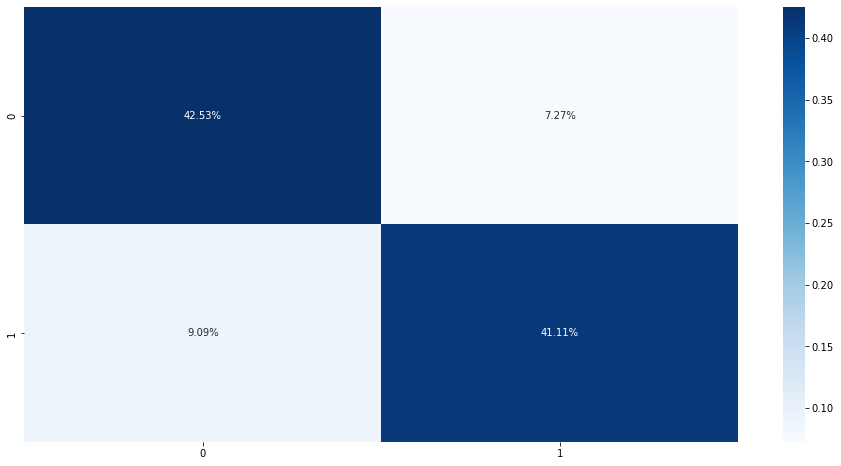

In [ ]:
cm = confusion_matrix(test_set['label'], train_labels_predictions)
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues');

### Logistic Regression Classifier

In [ ]:
%%time

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(train_set_vector, train_set['label'])

CPU times: user 22.1 s, sys: 27.6 s, total: 49.7 s
Wall time: 30.2 s


LogisticRegression(max_iter=1000)

In [ ]:
train_labels_predictions = cross_val_predict(lr_model, test_set_vector, test_set['label'], cv=3)

print('precision:\t%.3f' % precision_score(test_set['label'], train_labels_predictions))
print('recall:\t\t%.3f' % recall_score(test_set['label'], train_labels_predictions))
print('f1:\t\t%.3f' % f1_score(test_set['label'], train_labels_predictions))

precision:	0.848
recall:		0.867
f1:		0.858


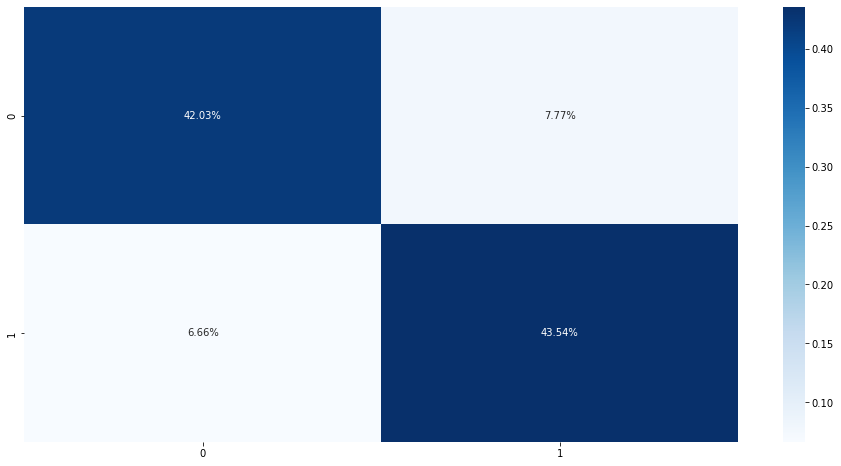

In [ ]:
cm = confusion_matrix(test_set['label'], train_labels_predictions)
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues');

### Decision Tree Classifier

In [ ]:
%%time

model = DecisionTreeClassifier()
model.fit(train_set_vector, train_set['label'])

CPU times: user 1min 23s, sys: 28.6 ms, total: 1min 23s
Wall time: 1min 23s


DecisionTreeClassifier()

In [ ]:
train_labels_predictions = cross_val_predict(model, test_set_vector, test_set['label'], cv=3)

print('precision:\t%.3f' % precision_score(test_set['label'], train_labels_predictions))
print('recall:\t\t%.3f' % recall_score(test_set['label'], train_labels_predictions))
print('f1:\t\t%.3f' % f1_score(test_set['label'], train_labels_predictions))

precision:	0.707
recall:		0.704
f1:		0.705


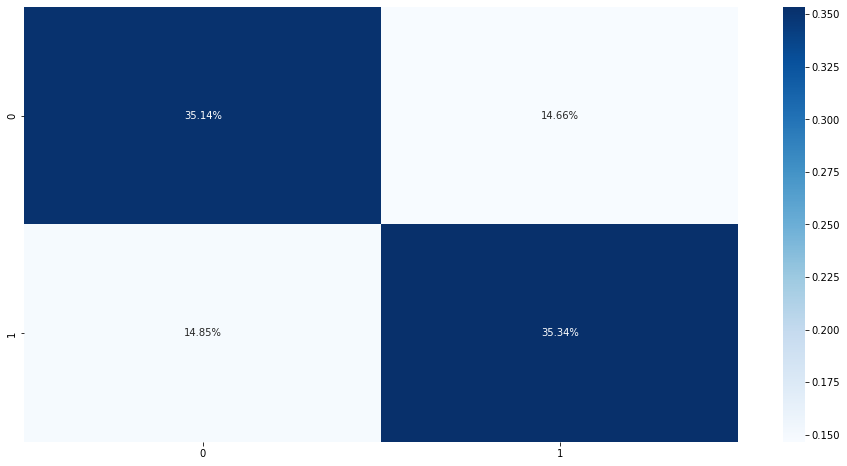

In [ ]:
cm = confusion_matrix(test_set['label'], train_labels_predictions)
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues');

### Hyperparameter tuning of Logistic Regression model

In [ ]:
model = LogisticRegression(max_iter=1000)

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [1.0, 0.5, 0.1, 0.01, 0.001]

grid = dict(solver=solvers, penalty=penalty, C=c_values)
logistic_regression_grid_search = GridSearchCV(estimator=model, param_grid=grid, cv=2, scoring='f1', verbose=3)
logistic_regression_grid_search.fit(train_set_vector, train_set['label']);

Fitting 2 folds for each of 15 candidates, totalling 30 fits
[CV 1/2] END C=1.0, penalty=l2, solver=newton-cg;, score=0.877 total time=  10.9s
[CV 2/2] END C=1.0, penalty=l2, solver=newton-cg;, score=0.872 total time=   7.3s
[CV 1/2] END ...C=1.0, penalty=l2, solver=lbfgs;, score=0.877 total time=  13.8s
[CV 2/2] END ...C=1.0, penalty=l2, solver=lbfgs;, score=0.872 total time=  12.4s
[CV 1/2] END C=1.0, penalty=l2, solver=liblinear;, score=0.877 total time=   4.8s
[CV 2/2] END C=1.0, penalty=l2, solver=liblinear;, score=0.872 total time=   7.1s
[CV 1/2] END C=0.5, penalty=l2, solver=newton-cg;, score=0.880 total time=   6.9s
[CV 2/2] END C=0.5, penalty=l2, solver=newton-cg;, score=0.875 total time=   8.6s
[CV 1/2] END ...C=0.5, penalty=l2, solver=lbfgs;, score=0.880 total time=   9.6s
[CV 2/2] END ...C=0.5, penalty=l2, solver=lbfgs;, score=0.875 total time=  11.2s
[CV 1/2] END C=0.5, penalty=l2, solver=liblinear;, score=0.880 total time=   4.4s
[CV 2/2] END C=0.5, penalty=l2, solver=li

In [ ]:
print(logistic_regression_grid_search.best_params_)

{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


In [ ]:
model = LogisticRegression(max_iter=1000, **logistic_regression_grid_search.best_params_)
model.fit(train_set_vector, train_set['label']);

train_labels_predictions = cross_val_predict(model, test_set_vector, test_set['label'], cv=3)

precision = precision_score(test_set['label'], train_labels_predictions)
recall = recall_score(test_set['label'], train_labels_predictions)
f1 = f1_score(test_set['label'], train_labels_predictions)

print('precision:\t%.3f' % precision)
print('recall:\t\t%.3f' % recall)
print('f1:\t\t%.3f' % f1)

precision:	0.853
recall:		0.874
f1:		0.864


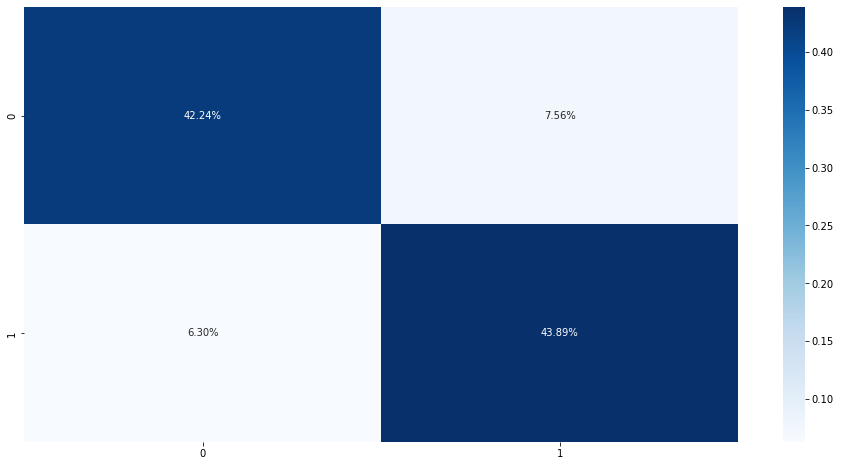

In [ ]:
cm = confusion_matrix(test_set['label'], train_labels_predictions)
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues');

### Saving the best model on Google Drive


In [ ]:
save_date = datetime.datetime.now().strftime("%Y%m%d")
model_name = 'logistic_regression'
model_hex = uuid.uuid4().hex

output = {
    "model_name": model_name,
    "model": model,
    "vectorizer": vectorizer,
    'model_hex': model_hex,
    'metrics': {
        'precision': precision,
        'recal': recall,
        'f1': f1,
      }
    }

with open(MODELS_DIR / f'{model_name}_{save_date}', 'wb') as fp:
  pickle.dump(output, fp)

### Saving the best model on Filebase

In [ ]:
s3_client = boto3.client('s3', endpoint_url='https://s3.filebase.com', aws_access_key_id=os.getenv('filebase_access_key_id'), aws_secret_access_key=os.getenv('filebase_secret_access_key'))


with open(MODELS_DIR / f'{model_name}_{save_date}', 'rb') as fp:
  s3_client.upload_fileobj(fp, BUCKET_NAME, model_hex)

### Test model on sample review

In [ ]:
example_review = "Horrible, horrible, horrible I can't believe how miscast this movie is. What was Ed Norton thinking when he signed up for this? Okay, it's a remake. If you saw the first hulk, you don't need to see this one. Feel free to avoid this one. And feel happy that you did."

text_string = vectorizer.transform([example_review])
print(LABELS[model.predict(text_string)[0]])

Nagative
